In [1]:
import os, sys
import numpy as np
import pandas as pd
import xarray as xr

import scipy.io as sio
from scipy import stats
from scipy import ndimage
from scipy.interpolate import griddata
import math
import random

import time
import datetime
from datetime import date
from datetime import timedelta
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.font_manager import FontProperties
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
from matplotlib.dates import AutoDateLocator, DateFormatter
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
from mpl_toolkits.basemap import Basemap

import xlrd 
import xlwt 
import xlsxwriter
import pathlib
from pathlib import Path

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.set_printoptions(formatter={'float': '{: 0.1f}'.format})

matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'
#matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['Times New Roman'] 
#plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False 

def get_filename(filename):
  (filepath,tempfilename) = os.path.split(filename);
  (shotname,extension) = os.path.splitext(tempfilename);
  #return filepath, shotname, extension
  return shotname

def Normaltime(str_time_input):
    Normaltime_output = datetime.strptime(str_time_input,'%Y-%m-%d %H_%M')
    return Normaltime_output

def Changestr(datetime_input):
    str_output = datetime_input.strftime('%Y-%m-%d %H:%M')
    return str_output

def TS(x):
    return (x - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
    #return datetime.utcfromtimestamp(x.astype('O')/1e9)
    #return datetime.fromtimestamp(x.tolist()/1e9)

def DT(x):
    return datetime.utcfromtimestamp(x)

def quantile_clip(group):
    group.plot()
    group[group < group.quantile(.02)] = group.quantile(.02)
    group[group > group.quantile(.98)] = group.quantile(.98)
    #group.plot()
    #plt.show()
    return group

def flat(nums):
    res = []
    for i in nums:
        if isinstance(i, list):
            res.extend(flat(i))
        else:
            res.append(i)
    return res

def excel_to_df(xlsx):
    df=pd.DataFrame(pd.read_excel(xlsx, sheet_name=get_filename(xlsx)))
    return df

In [3]:
file_PhotoRGB_AQI_Met = 'PhotoRGB_AQI_Met.xlsx'

PhotoRGB_AQI_Met=excel_to_df(file_PhotoRGB_AQI_Met)

In [4]:
print(PhotoRGB_AQI_Met.columns.values.tolist())

['Time', 'R_R_M', 'G_R_M', 'B_R_M', 'R_L_M', 'G_L_M', 'B_L_M', 'PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO', 'T2m', 'BLH', 'U10', 'V10', 'TP', 'SP', 'T_500', 'RH_500', 'U_500', 'V_500', 'GP_500', 'T_700', 'RH_700', 'U_700', 'V_700', 'GP_700', 'T_850', 'RH_850', 'U_850', 'V_850', 'GP_850']


In [5]:
Va_Phtoto=['R_R_M', 'G_R_M', 'B_R_M', 'R_L_M', 'G_L_M', 'B_L_M']

Va_AQI=[ 'PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO']

Va_Met_Ground=['T2m', 'BLH', 'U10', 'V10', 'TP', 'SP']
Va_Met_Levels=['T_500', 'U_500', 'V_500', 'T_700', 'U_700', 'V_700','T_850', 'U_850', 'V_850']

Va_TE=['GE_500','KE_850']

In [6]:
dfs=[PhotoRGB_AQI_Met]

for df in dfs:
    T_500=df['T_500']
    T_850=df['T_850']
    Ro_500=T_500.map(lambda x: 50000*29/(8314*(x+273.15)))
    Ro_850=T_850.map(lambda x: 85000*29/(8314*(x+273.15)))

    U_500=df['U_500']
    V_500=df['V_500']
    U_850=df['U_850']
    V_850=df['V_850']

    KE_500=0.5*Ro_500*(U_500**2+V_500**2)
    KE_850=0.5*Ro_850*(U_850**2+V_850**2)

    GP_500=df['GP_500']
    GP_850=df['GP_850']
    GE_500=Ro_500*GP_500
    GE_850=Ro_850*GP_850

    df['GE_500']=GE_500
    df['KE_500']=KE_500
    df['GE_850']=GE_850
    df['KE_850']=KE_850

In [7]:
def getdata_day(df):
    va=df.columns.values.tolist()
    day=df[va][df['R_R_M'] > 100]
    return day

def getdata_night(df):
    va=df.columns.values.tolist()
    night=df[va][df['R_R_M'] <100]
    return night

In [8]:
R_G_Sky= dfs[0]['R_R_M']/dfs[0]['G_R_M']
R_B_Sky = dfs[0]['R_R_M']/dfs[0]['B_R_M']
RGB_Sky = dfs[0]['R_R_M']+dfs[0]['G_R_M']+dfs[0]['B_R_M']
G_R_Sky= dfs[0]['G_R_M']/dfs[0]['R_R_M']
B_R_Sky= dfs[0]['B_R_M']/dfs[0]['R_R_M']

R_G_Ground= dfs[0]['R_L_M']/dfs[0]['G_L_M']
R_B_Ground = dfs[0]['R_L_M']/dfs[0]['B_L_M']
RGB_Ground = dfs[0]['R_L_M']+dfs[0]['G_L_M']+dfs[0]['B_L_M']

dfs[0]['R_G_Sky']=R_G_Sky
dfs[0]['R_B_Sky']=R_B_Sky
dfs[0]['B_R_Sky']=B_R_Sky
dfs[0]['RGB_Sky']=RGB_Sky
dfs[0]['R_G_Ground']=R_G_Ground
dfs[0]['R_B_Ground']=R_B_Ground
dfs[0]['RGB_Ground']=RGB_Ground

PM25 = dfs[0]['PM2.5']

GE_500=dfs[0]['GE_500']
BLH=dfs[0]['BLH']

dfs1_day=getdata_day(dfs[0])
dfs1_night=getdata_night(dfs[0])
print(dfs1_day.shape,dfs1_night.shape)

(3563, 45) (3119, 45)


Text(0.5, 1.0, 'BLH versus $PM_{2.5}$ in Beijing')

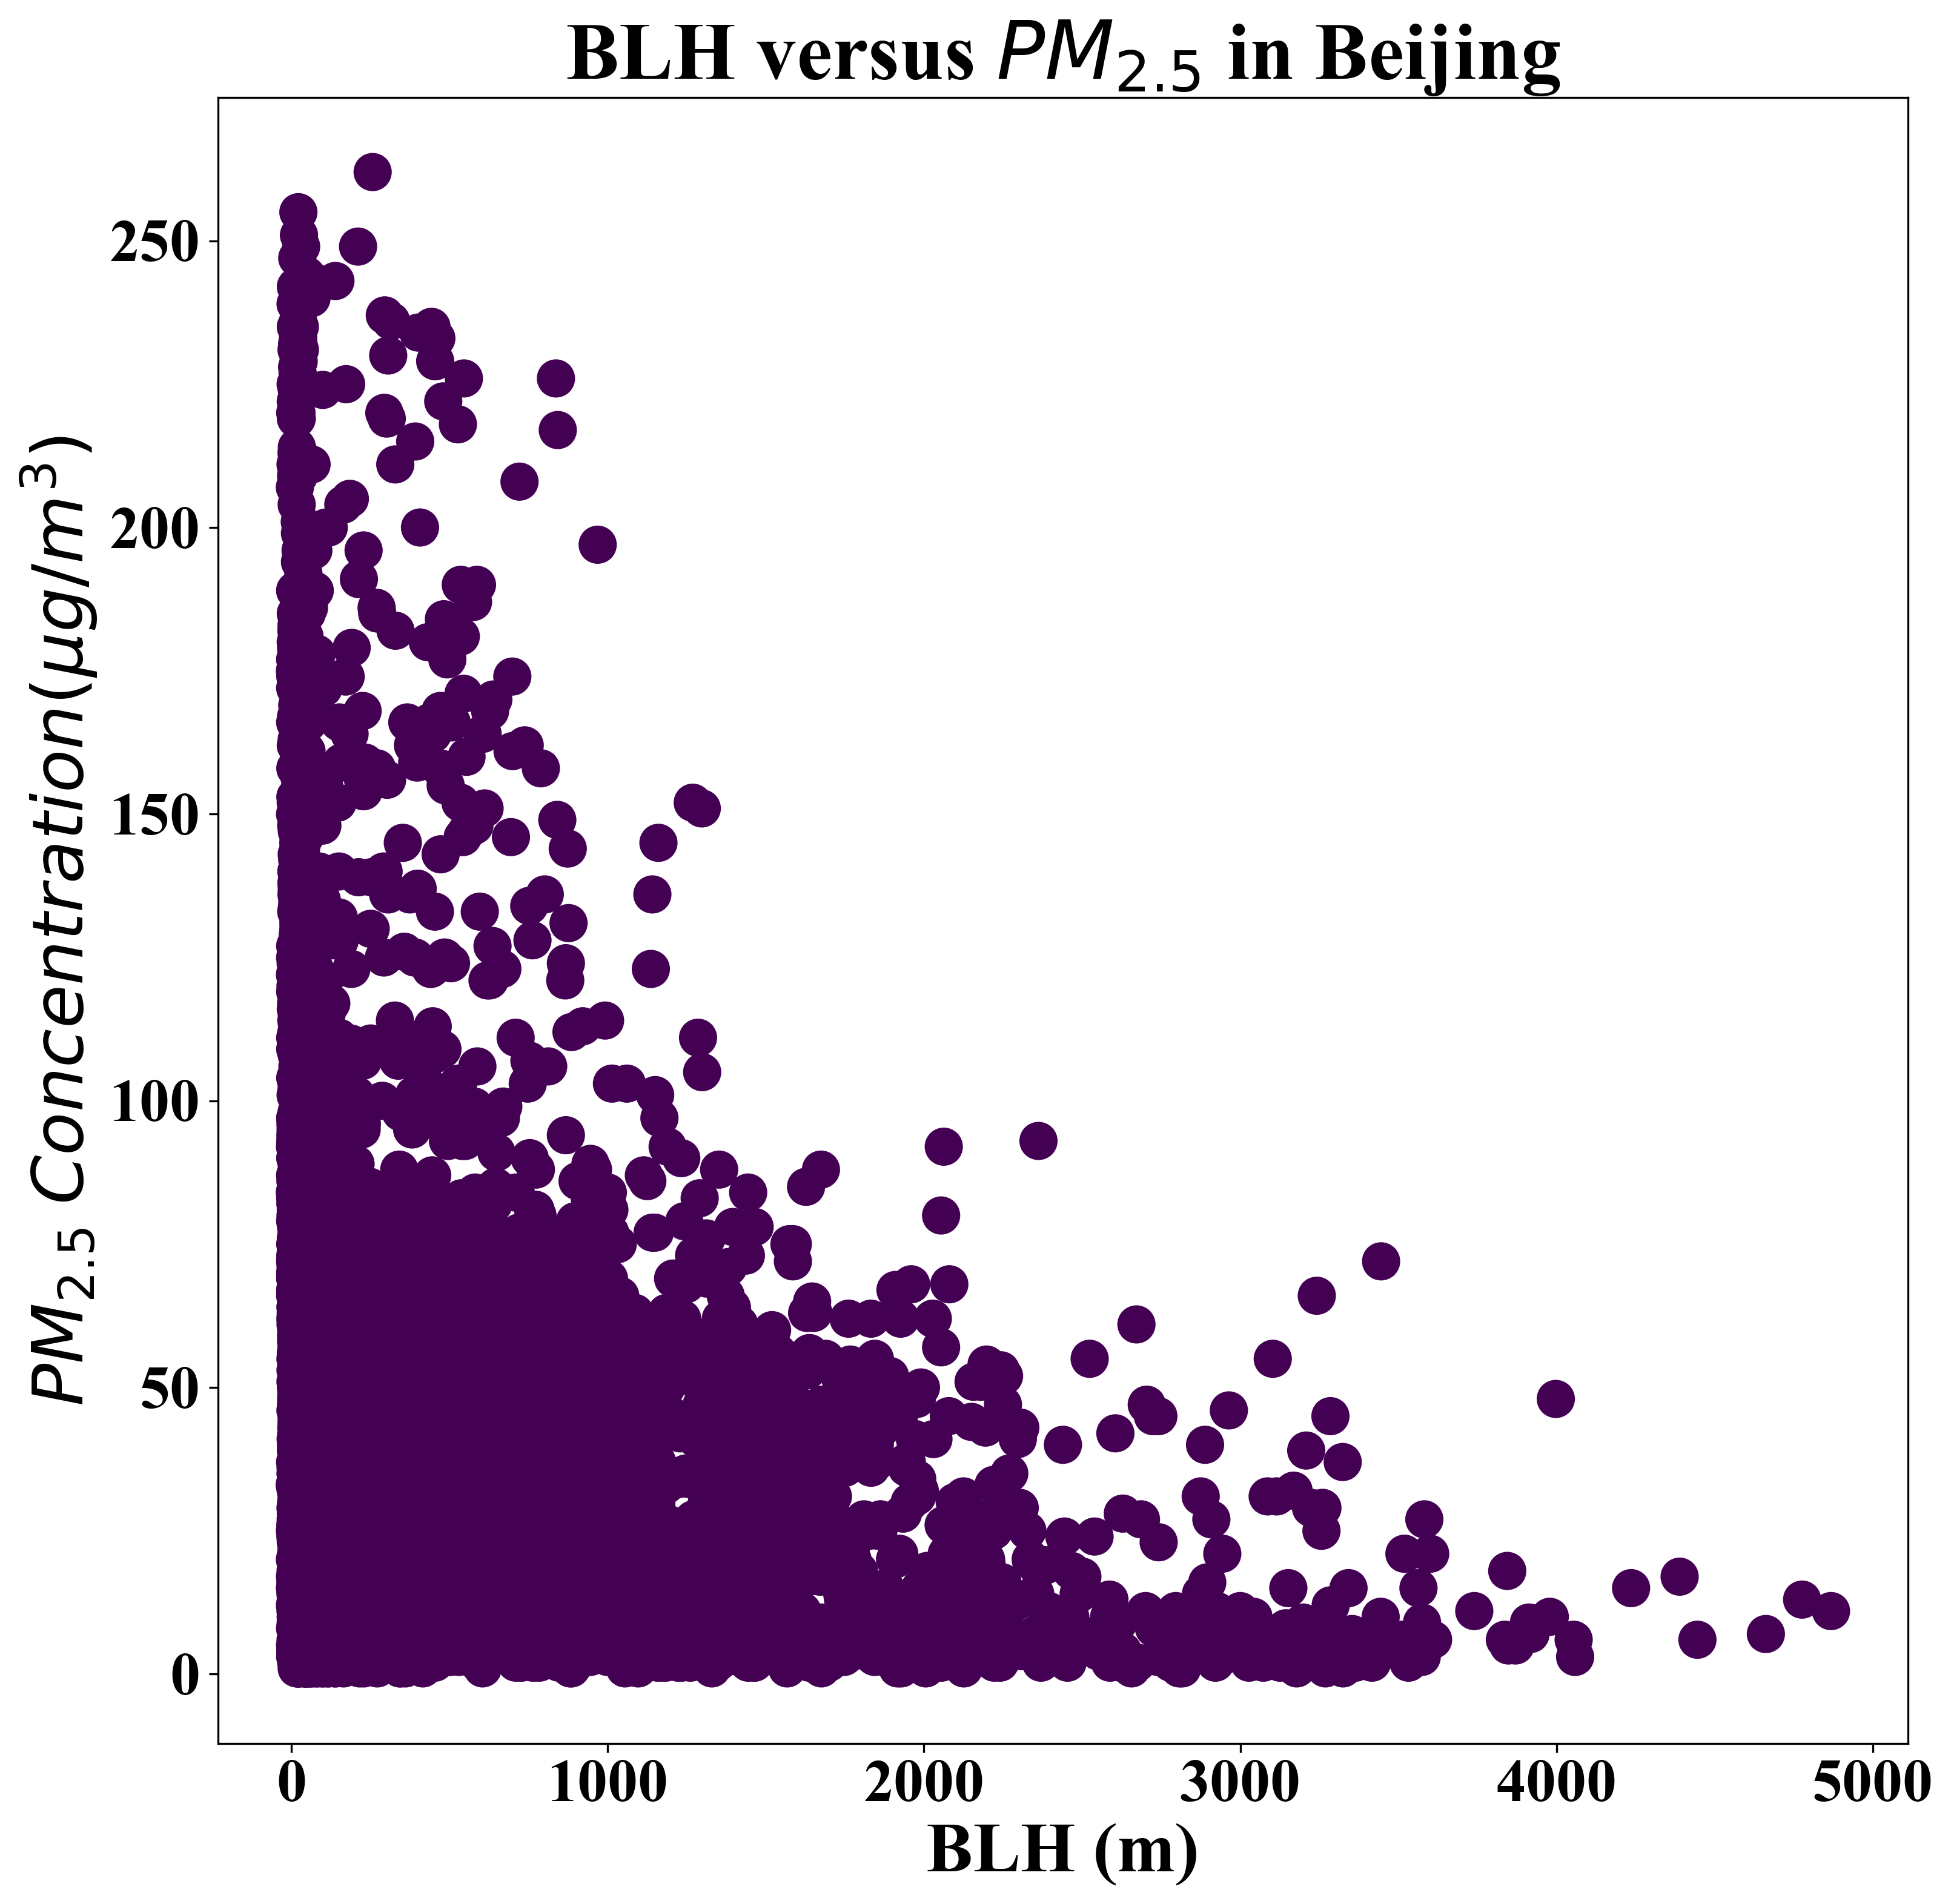

In [9]:
from sklearn import datasets , linear_model
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

X = BLH[:, np.newaxis]
y= PM25

kmeans = KMeans(n_clusters=1)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
fig, ax = plt.subplots(1,1,figsize=(12,12), dpi= 300)
ax.tick_params(labelsize=24)
ax.set_xlabel('BLH (m)', fontsize=28)
#ax.set_xlabel('Red/Green Ratio', fontsize=28)
ax.set_ylabel('$PM_{2.5}$'+ ' '+'$Concentration (µg/m^3)$', fontsize=28)
plt.scatter(X, y, c=y_kmeans, s=200, cmap='viridis')

#titlestr='Gravitational Potential Energy and  '+'$PM_{2.5}$'+' Concentration in Lanshan'
titlestr='BLH versus '+'$PM_{2.5}$'+ ' in Beijing'
plt.title(titlestr,fontsize=32)
#plt.savefig(str(titlestr)+'.png')

In [10]:
print(PM25.min(),PM25.max())

1.0 262.0


Text(0.5, 1.0, 'BLH versus $PM_{2.5}$ in Beijing')

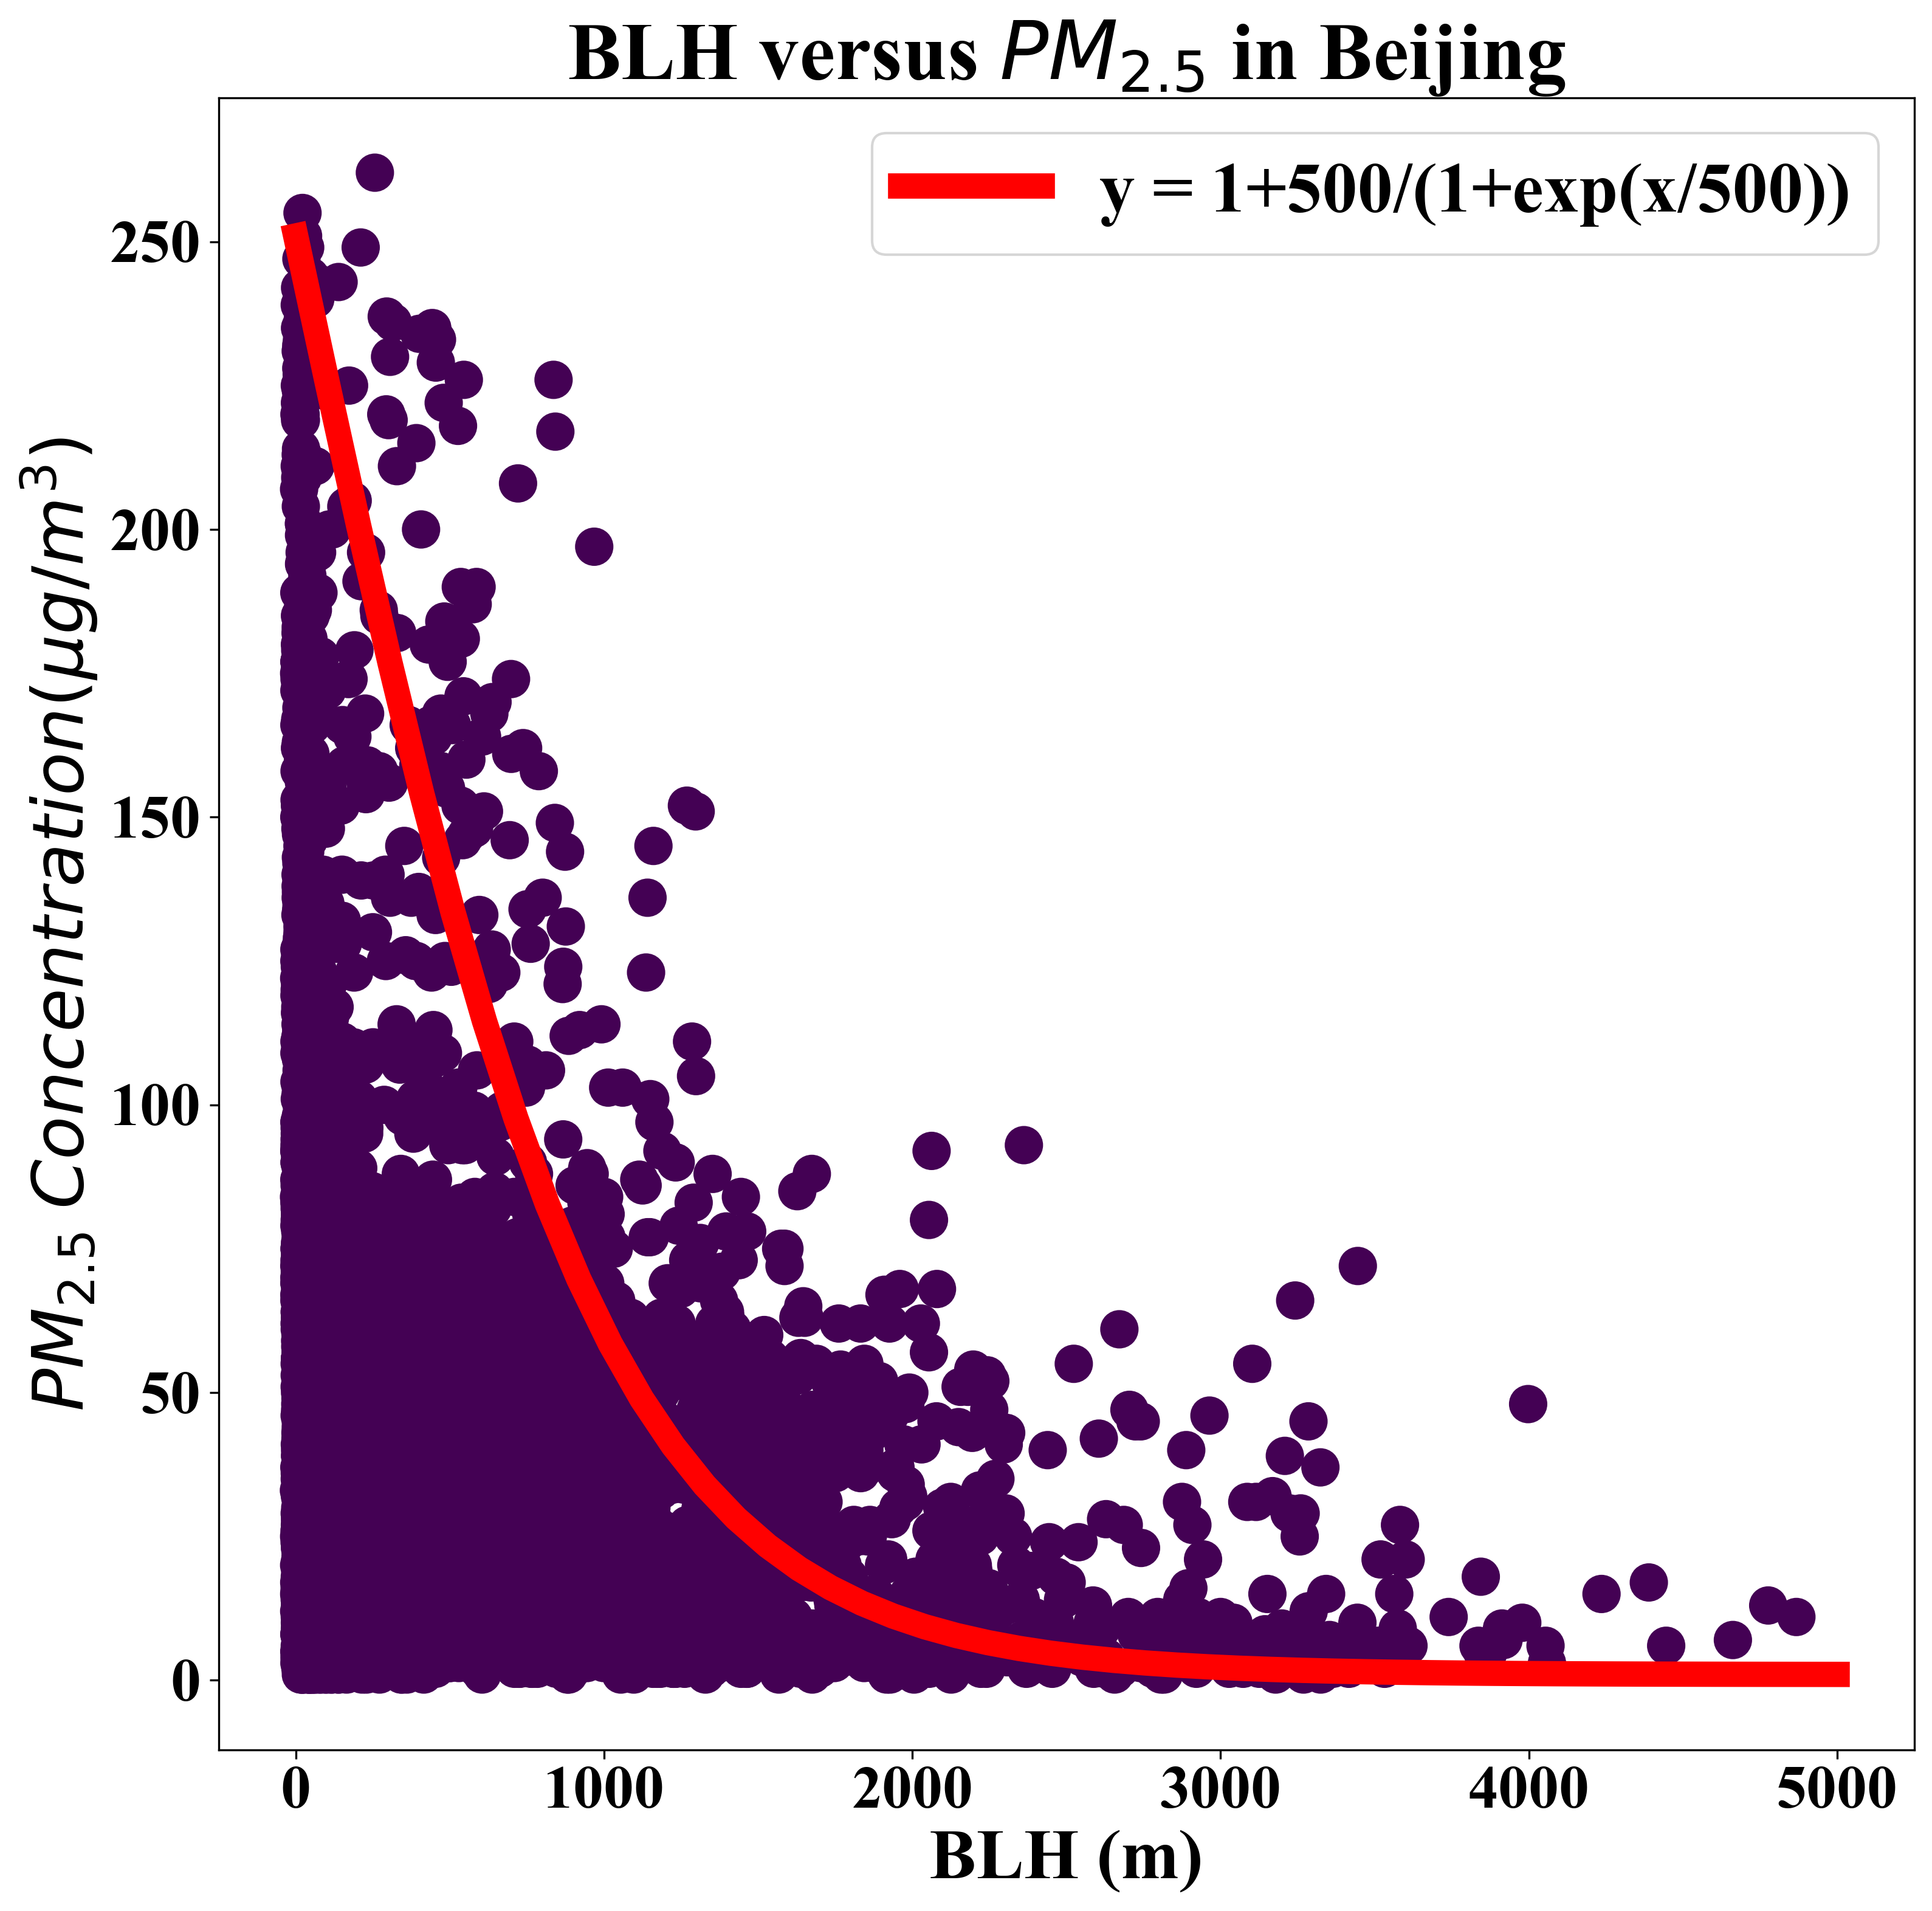

In [11]:
from scipy.optimize import curve_fit

def func_E(x):
    return 500/(1+np.exp(x/500)) + 1

#def func_P(x):
    return 261/(1+(x/500)**2) + 1

X = BLH[:, np.newaxis]
y= PM25

kmeans = KMeans(n_clusters=1)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

fig, ax = plt.subplots(1,1,figsize=(12,12), dpi= 300)
ax.tick_params(labelsize=24)
ax.set_xlabel('BLH (m)', fontsize=28)
ax.set_ylabel('$PM_{2.5}$'+ ' '+'$Concentration (µg/m^3)$', fontsize=28)
plt.scatter(X, y, c=y_kmeans, s=200, cmap='viridis')
X=np.linspace(0, 5000)
plt.plot(X, func_E(X), 'r-',linewidth=10, label='y = 1+500/(1+exp(x/500))')
#plt.plot(X, func_P(X), 'b-',linewidth=10, label='y = 1+261/(1+(x/500)^2)')
plt.legend(fontsize=28)
#plt.ylim(0,300)
#plt.xlim(0,5000) 

titlestr='BLH versus '+'$PM_{2.5}$'+ ' in Beijing'
plt.title(titlestr,fontsize=32)

In [12]:
df=dfs[0].dropna()
Xdata=df['BLH']
Ydata=df['PM2.5']

### Calculate R Square ###
calc_ydata = [func_E(i) for i in Xdata]
res_ydata  = np.array(Ydata) - np.array(calc_ydata)
ss_res     = np.sum(res_ydata**2)
ss_tot     = np.sum((Ydata - np.mean(Ydata))**2)
r_squared  = 1 - (ss_res / ss_tot)

print ('R^2: %.3f' % (r2_score(np.array(Ydata),calc_ydata)))

print(" R2 = %f"%(r_squared))

R^2: -12.242
 R2 = -12.241569


In [13]:
df=dfs1_day

Text(0.5, 1.0, 'Blue/Red Ratio in Sky Versus $PM_{2.5}$ in Daytime')

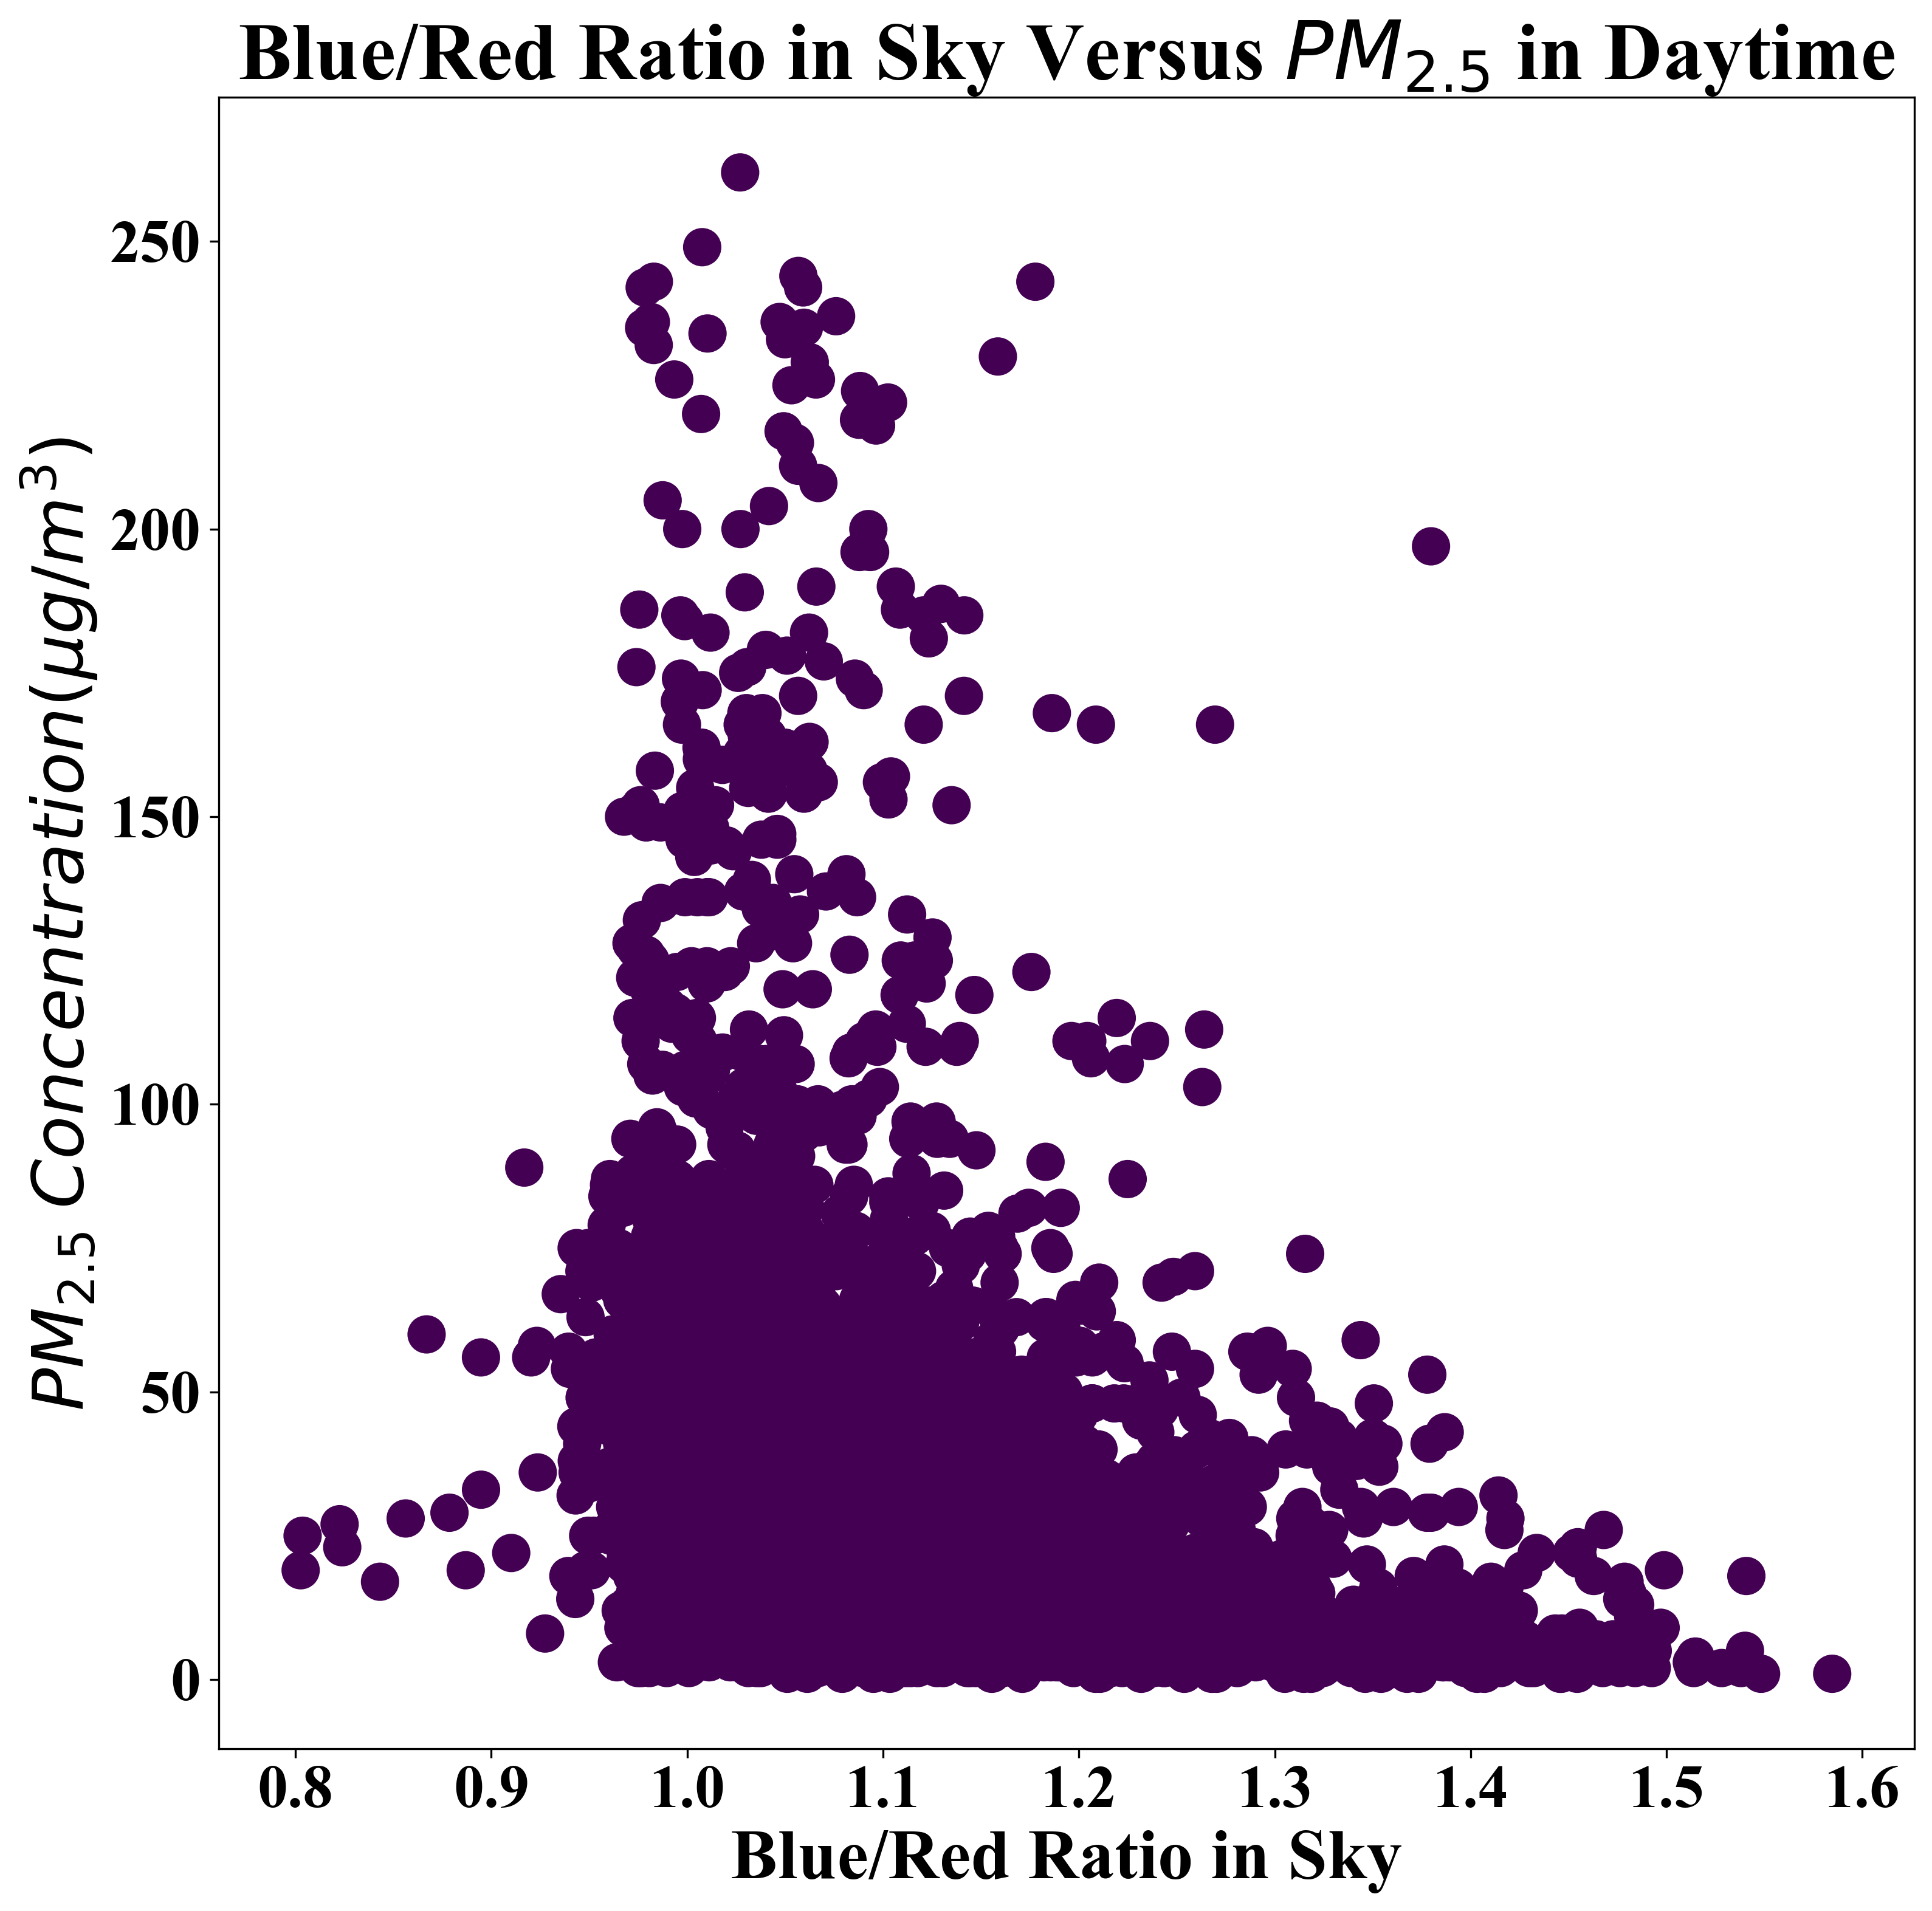

In [14]:
X = df['B_R_Sky'][:, np.newaxis]
y= df['PM2.5']

kmeans = KMeans(n_clusters=1)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
fig, ax = plt.subplots(1,1,figsize=(12,12), dpi= 300)
ax.tick_params(labelsize=24)
ax.set_xlabel('Blue/Red Ratio in Sky', fontsize=28)
#ax.set_xlabel('Red/Green Ratio', fontsize=28)
ax.set_ylabel('$PM_{2.5}$'+ ' '+'$Concentration (µg/m^3)$', fontsize=28)
plt.scatter(X, y, c=y_kmeans, s=200, cmap='viridis')

#titlestr='Gravitational Potential Energy and  '+'$PM_{2.5}$'+' Concentration in Lanshan'
titlestr='Blue/Red Ratio in Sky Versus '+'$PM_{2.5}$'+ ' in Daytime'
plt.title(titlestr,fontsize=32)
#plt.savefig(str(titlestr)+'.png')

Text(0.5, 1.0, 'Blue/Red Ratio in Sky Versus $PM_{2.5}$ in Daytime')

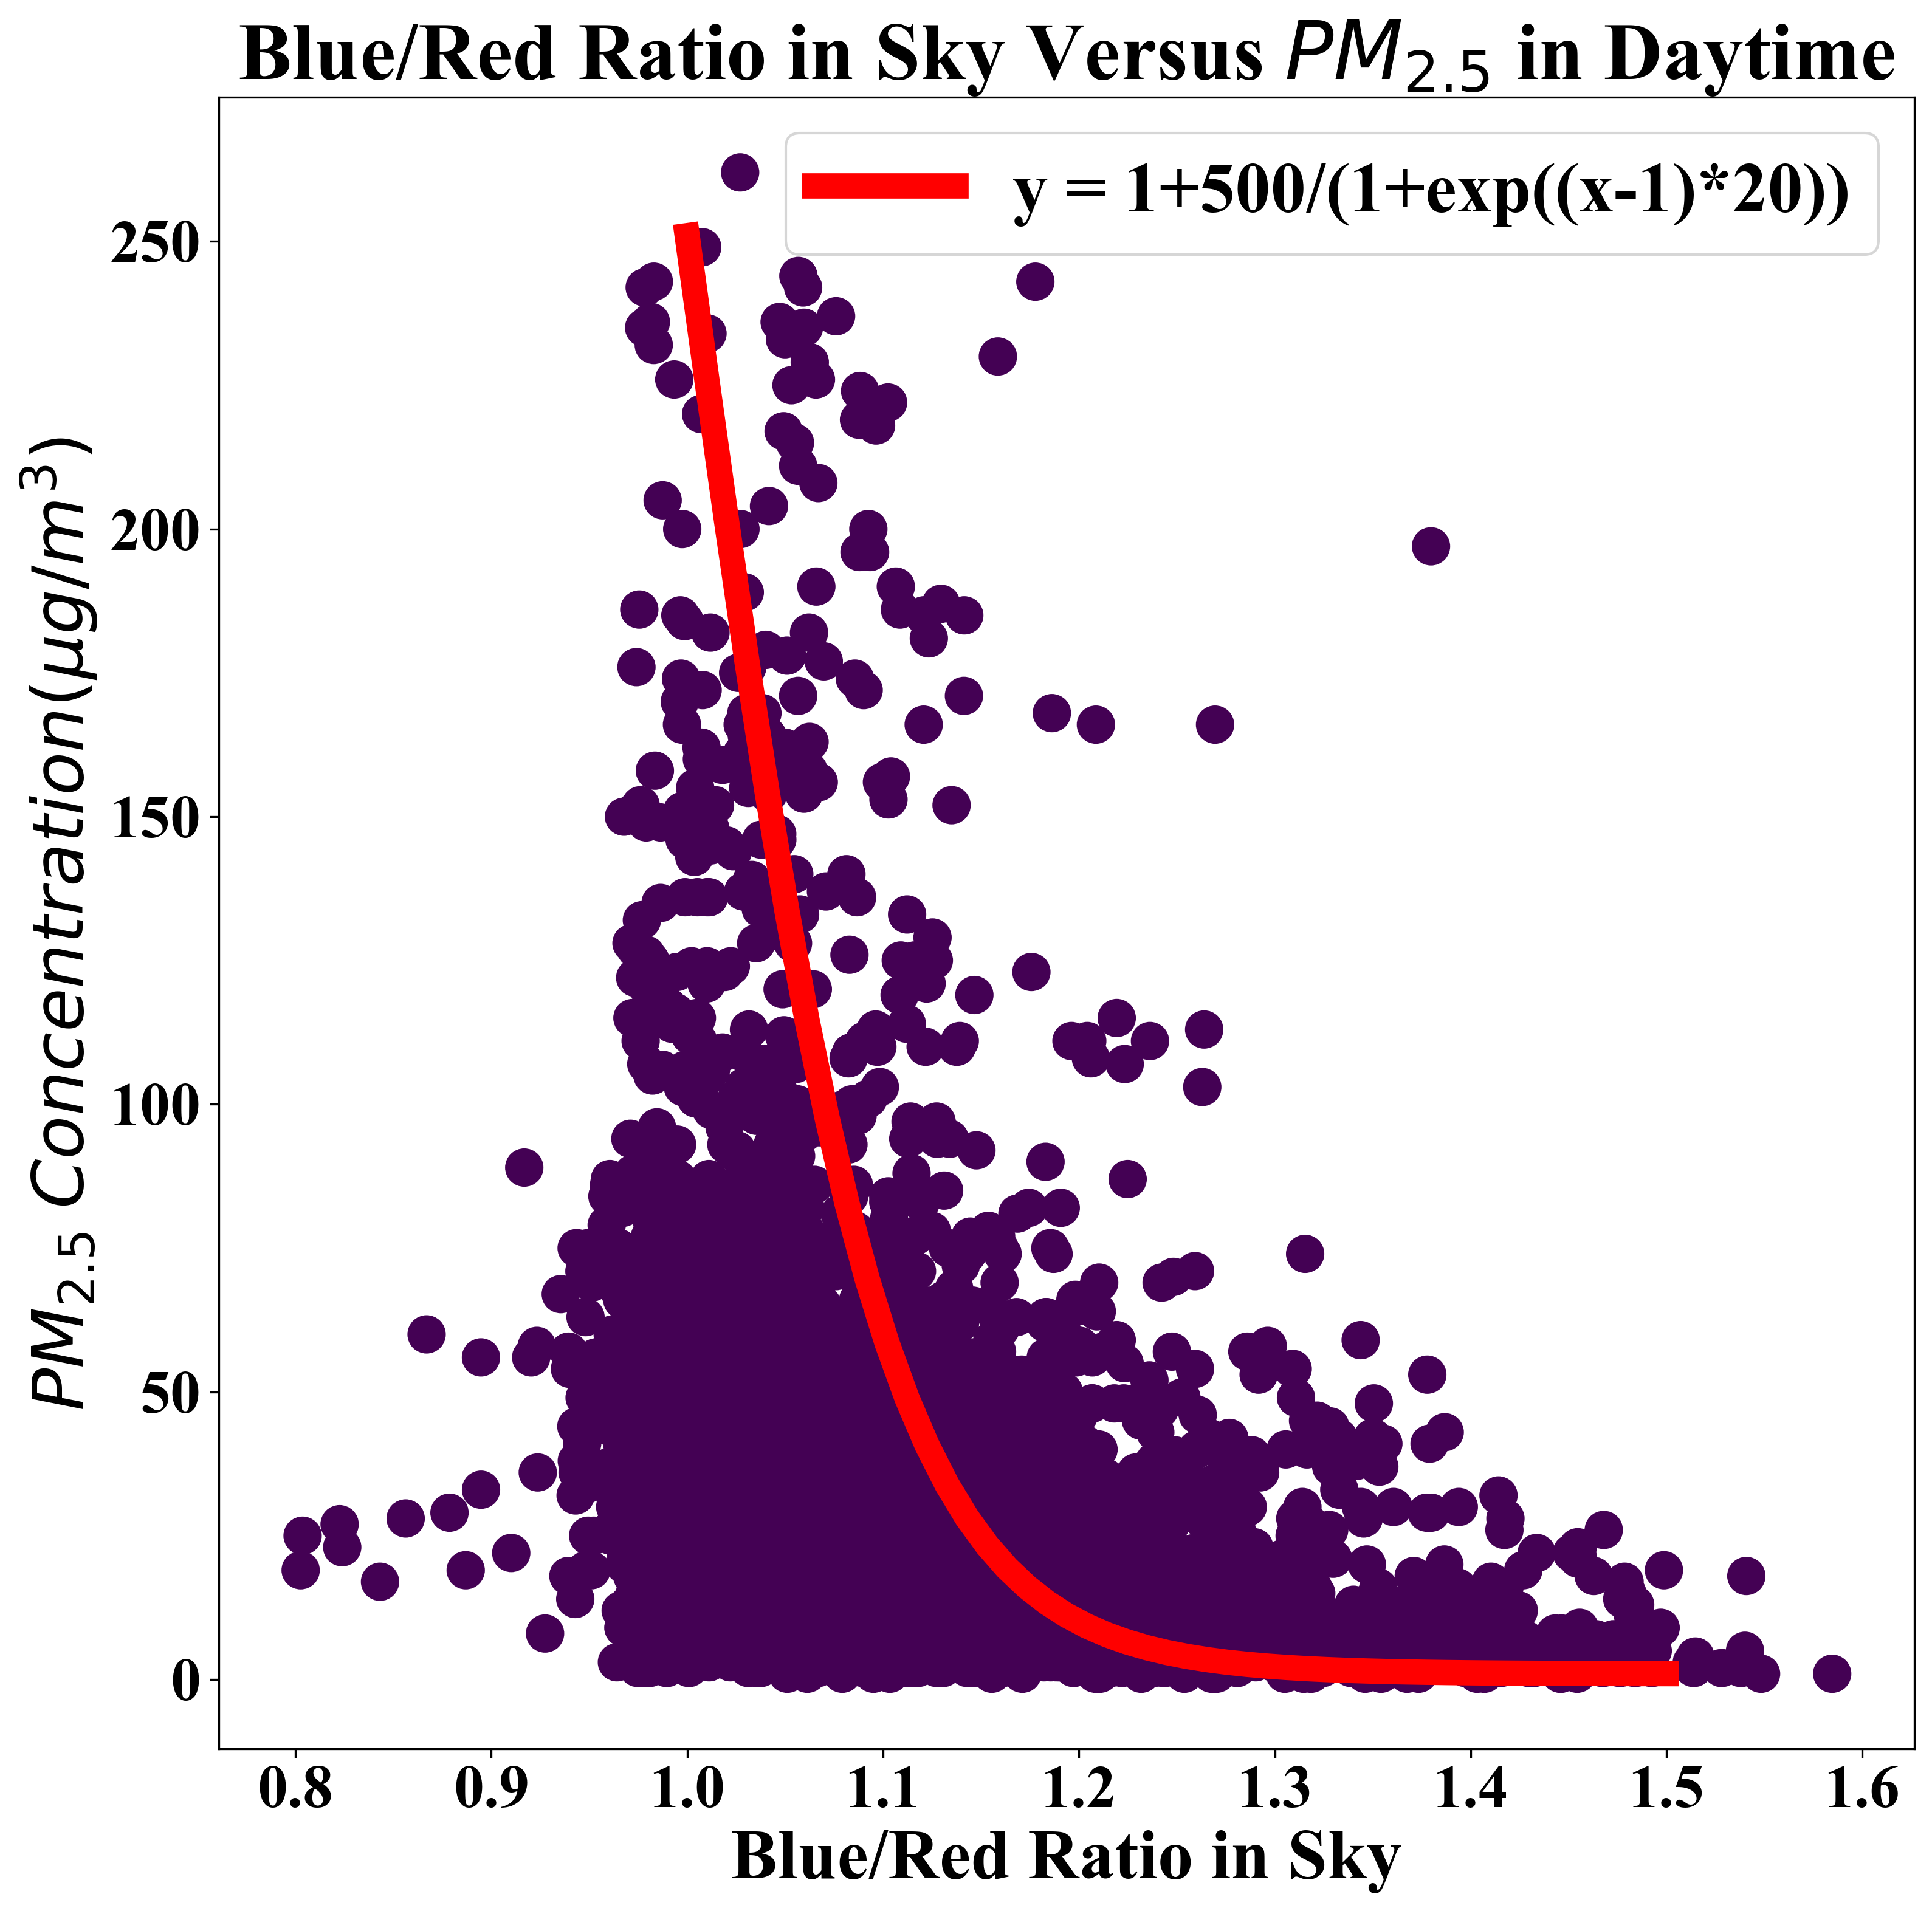

In [15]:
from scipy.optimize import curve_fit

def func_E(x):
    return 500/(1+np.exp((x-1)*20)) + 1

#def func_P(x):
    return 262/(1+((x-1)/20)**2) + 1

X = df['B_R_Sky'][:, np.newaxis]
y= df['PM2.5']

kmeans = KMeans(n_clusters=1)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

fig, ax = plt.subplots(1,1,figsize=(12,12), dpi= 300)
ax.tick_params(labelsize=24)
ax.set_xlabel('Blue/Red Ratio in Sky', fontsize=28)
ax.set_ylabel('$PM_{2.5}$'+ ' '+'$Concentration (µg/m^3)$', fontsize=28)
plt.scatter(X, y, c=y_kmeans, s=200, cmap='viridis')
X=np.linspace(1.0, 1.5)
plt.plot(X, func_E(X), 'r-',linewidth=10, label='y = 1+500/(1+exp((x-1)*20))')
#plt.plot(X, func_P(X), 'b-',linewidth=10, label='y = 1+261/(1+(x/500)^2)')
plt.legend(fontsize=28)
#plt.ylim(0,300)
#plt.xlim(0,5000) 

titlestr='Blue/Red Ratio in Sky Versus '+'$PM_{2.5}$'+ ' in Daytime'
plt.title(titlestr,fontsize=32)

In [16]:
df=df.dropna()
Xdata=df['B_R_Sky']
Ydata=df['PM2.5']

### Calculate R Square ###
calc_ydata = [func_E(i) for i in Xdata]
res_ydata  = np.array(Ydata) - np.array(calc_ydata)
ss_res     = np.sum(res_ydata**2)
ss_tot     = np.sum((Ydata - np.mean(Ydata))**2)
r_squared  = 1 - (ss_res / ss_tot)

print ('R^2: %.3f' % (r2_score(np.array(Ydata),calc_ydata)))

print(" R2 = %f"%(r_squared))

R^2: -10.261
 R2 = -10.260653


Text(0.5, 1.0, 'RGB in Ground Versus $PM_{2.5}$ in Nighttime')

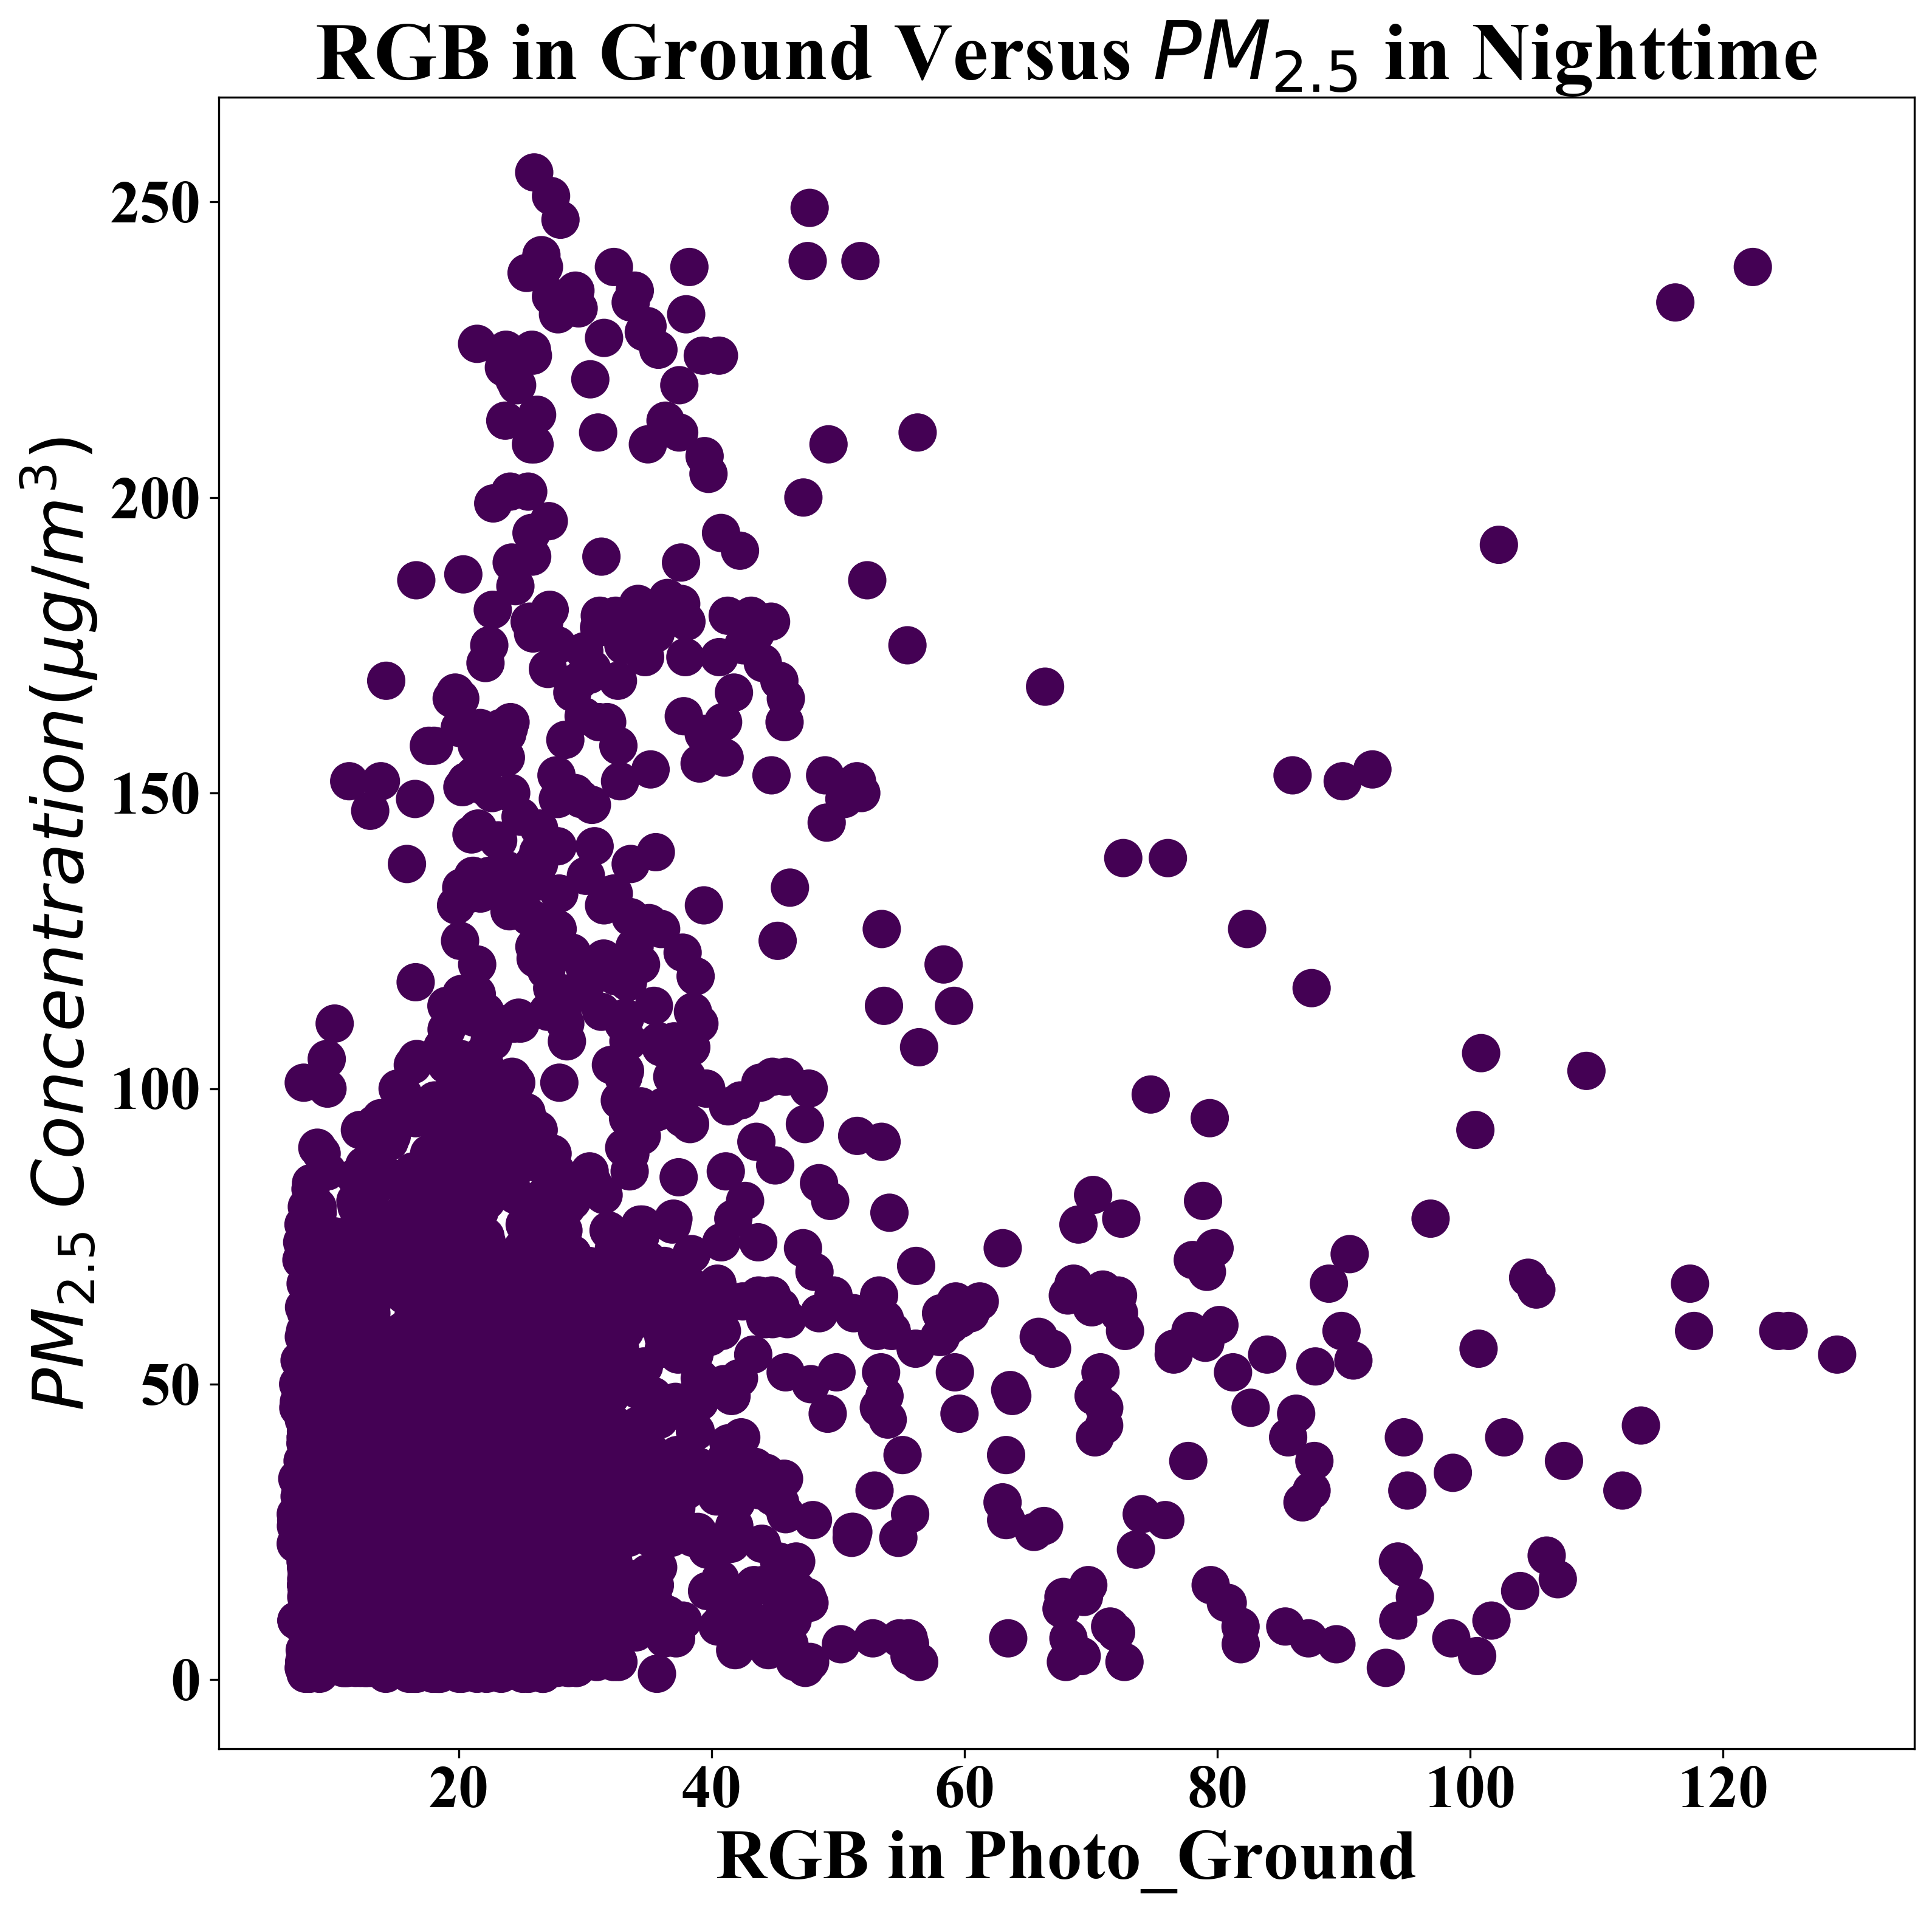

In [17]:
RGB_N = dfs1_night['R_L_M']+dfs1_night['G_L_M']+dfs1_night['B_L_M']

X = RGB_N[:, np.newaxis]

y= dfs1_night['PM2.5']

kmeans = KMeans(n_clusters=1)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
fig, ax = plt.subplots(1,1,figsize=(12,12), dpi= 300)
ax.tick_params(labelsize=24)
#ax.set_xlabel('Red/Blue Ratio', fontsize=28)
ax.set_xlabel('RGB in Photo_Ground', fontsize=28)
ax.set_ylabel('$PM_{2.5}$'+ ' '+'$Concentration (µg/m^3)$', fontsize=28)
plt.scatter(X, y, c=y_kmeans, s=200, cmap='viridis')

#titlestr='Gravitational Potential Energy and  '+'$PM_{2.5}$'+' Concentration in Lanshan'
titlestr='RGB in Ground Versus '+'$PM_{2.5}$'+ ' in Nighttime'
plt.title(titlestr,fontsize=32)
#plt.savefig(str(titlestr)+'.png')